In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
data = np.load("data.npy")

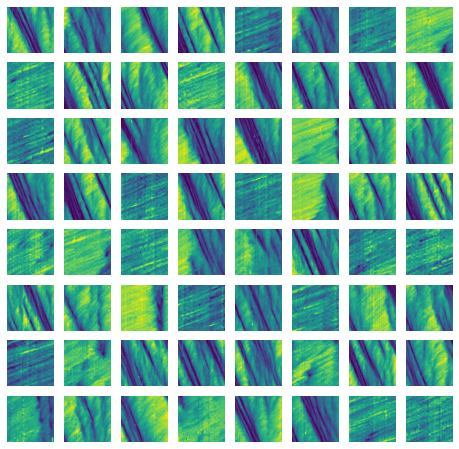

In [3]:
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(data[np.random.randint(data.shape[0])][0].T, origin="lower" )
        ax[i, j].axis("off")

In [4]:
# Normalize the data with min-max scaling

data_min = 0 # data.min()
data_max = data.max()

data = (data - data_min) / (data_max - data_min)

In [5]:
# Split the data into training and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [8]:
class RealNVP(nn.Module):
    def __init__(self, num_coupling_layers, input_dim, hidden_dim):
        super(RealNVP, self).__init__()
        self.coupling_layers = nn.ModuleList([CouplingLayer(input_dim, hidden_dim) for _ in range(num_coupling_layers)])

    def forward(self, x):
        log_det_J = torch.zeros(x.size(0), device=x.device)
        for layer in self.coupling_layers:
            x, log_det_j = layer(x)
            log_det_J += log_det_j
        return x, log_det_J

    def inverse(self, z):
        for layer in reversed(self.coupling_layers):
            z = layer.inverse(z)
        return z

class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CouplingLayer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.scale = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2)
        )

        self.translate = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2)
        )

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        s = self.scale(x1)
        t = self.translate(x1)
        y1 = x1
        y2 = x2 * torch.exp(s) + t
        y = torch.cat([y1, y2], dim=1)
        log_det_j = s.sum(dim=1)
        return y, log_det_j

    def inverse(self, y):
        y1, y2 = y.chunk(2, dim=1)
        s = self.scale(y1)
        t = self.translate(y1)
        x2 = (y2 - t) * torch.exp(-s)
        x = torch.cat([y1, x2], dim=1)
        return x

In [ ]:
# Initialize model, optimizer, and loss function
input_dim = 4 * 64 * 64
hidden_dim = 64
num_coupling_layers = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RealNVP(num_coupling_layers, input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(train_loader):
        batch = batch.view(batch.size(0), -1).to(device).float()
        z, log_det_J = model(batch)
        log_pz = torch.distributions.Normal(0, 1).log_prob(z).sum(dim=1)
        loss = -torch.mean(log_pz + log_det_J)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

# Save the model after training
torch.save(model.state_dict(), 'realnvp.pth')
print("RealNVP model saved.")

100%|██████████| 125/125 [00:09<00:00, 13.30it/s]


Epoch 1/200, Loss: 3369578547.234719


100%|██████████| 125/125 [00:05<00:00, 21.14it/s]


Epoch 6/200, Loss: 19228.116578125


100%|██████████| 125/125 [00:05<00:00, 21.46it/s]


Epoch 11/200, Loss: 8252.8700078125


100%|██████████| 125/125 [00:05<00:00, 22.26it/s]


Epoch 16/200, Loss: 5437.04040625


100%|██████████| 125/125 [00:05<00:00, 21.86it/s]


Epoch 21/200, Loss: 4102.79984765625


 42%|████▏     | 53/125 [00:02<00:03, 19.82it/s]

In [ ]:
# Initialize model, optimizer, and loss function
input_dim = 4 * 64 * 64
hidden_dim = 64
num_coupling_layers = 5
device = "cpu"

model = RealNVP(num_coupling_layers, input_dim, hidden_dim).to(device)
model.load_state_dict(torch.load('realnvp.pth', map_location=device))
model.eval()

# Sample from the latent space
with torch.no_grad():
    z = torch.randn(64, input_dim).to(device)
    sample = model.inverse(z)

# Reshape and scale the sample
sample = sample.view(-1, 4, 64, 64)
sample = sample.permute(0, 2, 3, 1).cpu().numpy()

# Convert and visualize the sample
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(sample[i * 8 + j][:, :, 0], cmap='gray', origin="lower")
        ax[i, j].axis("off")
plt.show()
